In [2]:
from numpy import *
import numpy
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas
import datetime
import seaborn

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn import metrics

import sys
sys.path.append("/Users/efandel/Desktop/iPython Tools")
from rtbpythonutils import *
%matplotlib inline

In [3]:
feature_columns = ['app_site_id', 'publisher_id', 'fiksu_app_id', 'creative_id', 'lam_status', 'ad_type', 'ad_size', 'ad_network',
                   'device_country', 'fiksu_device', 'connection_speed', 'monthly_imps', 'device_osv']
negative_ratio = 1.0

positives = redshift_compute('''
select case when conversions > 0 then 1 else 0 end as label,
  %s
from research_prod.bid_summary_4wk
where fiksu_app_id != '0'
  and used_target = 'cost_per_download'
  and conversions > 0
order by random()
limit 100000
'''%(', '.join(feature_columns)))

negatives = redshift_compute('''
select case when conversions > 0 then 1 else 0 end as label,
  %s
from research_prod.bid_summary_4wk
where fiksu_app_id != '0'
  and used_target = 'cost_per_download'
  and conversions = 0
  and impressions > 0
order by random()
limit %s
'''%(', '.join(feature_columns), int(len(positives)*negative_ratio)))
all_data = pandas.concat([positives, negatives])

def random_split(X,Y, frac=0.8):
    msk = numpy.random.rand(len(X)) < frac
    return X[msk], Y[msk], X[~msk], Y[~msk]

In [4]:
print(all_data.columns.values)

[u'label' u'app_site_id' u'publisher_id' u'fiksu_app_id' u'creative_id'
 u'lam_status' u'ad_type' u'ad_size' u'ad_network' u'device_country'
 u'fiksu_device' u'connection_speed' u'monthly_imps' u'device_osv']


In [5]:
columns = ['app_site_id', 'fiksu_app_id', 'ad_type', 'connection_speed']
X = pandas.get_dummies(all_data[columns])
Y = all_data['label']

X_train, Y_train, X_test, Y_test = random_split(X, Y)

Logistic Regression
('Training Accuracy', 63.84)
('Test Accuracy', 63.1)
('Training Loss', 0.62189696374346592)
('Test Loss', 0.62881543236216841)
('Mean Loss', 0.69315253076782957)


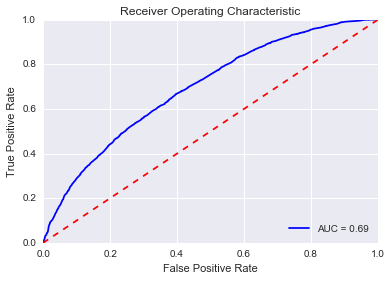

In [6]:
method = "Logistic Regression"


model = LogisticRegression()
model.fit(X_train, Y_train)

train_acc = round(model.score(X_train, Y_train) * 100, 2)
test_acc = round(model.score(X_test, Y_test) * 100, 2)

train_loss = sklearn.metrics.log_loss(Y_train, model.predict_proba(X_train)[:,1])
test_loss = sklearn.metrics.log_loss(Y_test, model.predict_proba(X_test)[:,1])

mean_loss = sklearn.metrics.log_loss(Y_test, ones(len(Y_test)) * mean(Y_train))


print(method)
print("Training Accuracy", train_acc)
print("Test Accuracy", test_acc)
print("Training Loss", train_loss)
print("Test Loss", test_loss)
print("Mean Loss", mean_loss)

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decision Tree
('Training Accuracy', 54.61)
('Test Accuracy', 54.1)
('Training Loss', 0.66919650199803293)
('Test Loss', 0.68217779248971111)
('Mean Loss', 0.69315253076782957)


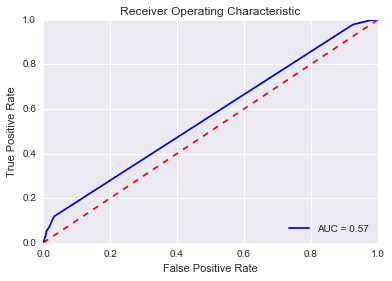

In [9]:
method = "Decision Tree"

model = DecisionTreeClassifier(max_depth = 8)
model.fit(X_train, Y_train)

train_acc = round(model.score(X_train, Y_train) * 100, 2)
test_acc = round(model.score(X_test, Y_test) * 100, 2)

train_loss = sklearn.metrics.log_loss(Y_train, model.predict_proba(X_train)[:,1])
test_loss = sklearn.metrics.log_loss(Y_test, model.predict_proba(X_test)[:,1])

mean_loss = sklearn.metrics.log_loss(Y_test, ones(len(Y_test)) * mean(Y_train))


print(method)
print("Training Accuracy", train_acc)
print("Test Accuracy", test_acc)
print("Training Loss", train_loss)
print("Test Loss", test_loss)
print("Mean Loss", mean_loss)

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [10]:
from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file=dotfile, feature_names=X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

Random Forest
('Training Accuracy', 66.68)
('Test Accuracy', 63.89)
('Training Loss', 0.58686880292393218)
('Test Loss', 0.77076128908241892)
('Mean Loss', 0.6931490648984544)


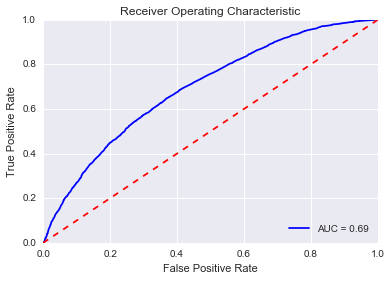

In [6]:
method="Random Forest"

model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, Y_train)

train_acc = round(model.score(X_train, Y_train) * 100, 2)
test_acc = round(model.score(X_test, Y_test) * 100, 2)

train_loss = sklearn.metrics.log_loss(Y_train, model.predict_proba(X_train)[:,1])
test_loss = sklearn.metrics.log_loss(Y_test, model.predict_proba(X_test)[:,1])

mean_loss = sklearn.metrics.log_loss(Y_test, ones(len(Y_test)) * mean(Y_train))


print(method)
print("Training Accuracy", train_acc)
print("Test Accuracy", test_acc)
print("Training Loss", train_loss)
print("Test Loss", test_loss)
print("Mean Loss", mean_loss)

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Naive Bayes
('Training Accuracy', 54.47)
('Test Accuracy', 53.76)
('Training Loss', 15.726894161881033)
('Test Loss', 15.972203867415727)
('Mean Loss', 0.6931490648984544)


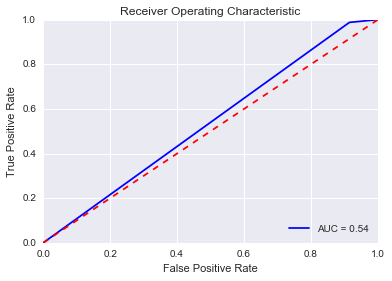

In [5]:
method="Naive Bayes"

model = GaussianNB()
model.fit(X_train, Y_train)

train_acc = round(model.score(X_train, Y_train) * 100, 2)
test_acc = round(model.score(X_test, Y_test) * 100, 2)

train_loss = sklearn.metrics.log_loss(Y_train, model.predict_proba(X_train)[:,1])
test_loss = sklearn.metrics.log_loss(Y_test, model.predict_proba(X_test)[:,1])

mean_loss = sklearn.metrics.log_loss(Y_test, ones(len(Y_test)) * mean(Y_train))


print(method)
print("Training Accuracy", train_acc)
print("Test Accuracy", test_acc)
print("Training Loss", train_loss)
print("Test Loss", test_loss)
print("Mean Loss", mean_loss)

probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()